In [1]:
import os
directory = "please_add_directory"
os.chdir(directory)

from Scripts import Utilities as ut
from Scripts import Feature_Extraction as fe
from Scripts import Model_Training as mt
from Scripts import data_loading as dl
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
dataset = "urbansound8k"

C:\Users\giorg\miniconda3\envs\dl\Lib\site-packages\pyAudioAnalysis\..\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Pipeline

There are two option to train a model here.

1. Download the dataset from the OFICIAL source and export it inside the folde UrbanSound

2. Download the features from the google drive link we provide and add it at the UrbanSound Folder.

If you go with the second option please start running this notebook from Fully Connected section and after

This command created the tarin and test csvs to work with

In [2]:
# Seperate the test folder for it to not be messed in th training process
ut.split_train_test(dataset, "UrbanSound\\UrbanSound8K\\metadata\\UrbanSound8K.csv", "UrbanSound\\CSVs\\Train_csv", "UrbanSound\\CSVs\\Test_csv")

The next commands seperated the files from the original dataset to Train and Test Folders

In [ ]:
# Put files in Train and Test folders
ut.move_train_test_folder("UrbanSound\\CSVs\\Train_csv","UrbanSound\\Train","UrbanSound\\UrbanSound8K\\audio")

ut.move_train_test_folder("UrbanSound\\CSVs\\Test_csv","UrbanSound\\Test","UrbanSound\\UrbanSound8K\\audio")

Now files are aranged into folders where folder name = Category

In [ ]:
# In train folder put evry file in the corespondiong category
ut.move_to_class_folder("UrbanSound\\CSVs\\Train_csv","UrbanSound\\Train",dataset)

# Fully Connected

Before extracting features, some files need to be deleted. There was no way to error handle this because it was part of the PyAudioanalysis library.

If a file fails at the end of the procedure, add the prefix and the folder to the files below, delete it, and start extracting features from scratch.

After that, features are extracted with a call to MidTermFeatures from the PyAudioAnalysis library, and the features are saved as a numpy file in the UrbanSound\Features\NN_features directory.

In [ ]:

children_playing_folder = 'UrbanSound/Train/children_playing'
drilling_folder = 'UrbanSound/Train/drilling'
jackhammer_folder = 'UrbanSound/Train/jackhammer'

children_playing_prefix = '36429'
drilling_prefix = '19007'
jackhammer_prefix = '88466'

ut.delete_files_with_prefix(children_playing_folder, children_playing_prefix)
ut.delete_files_with_prefix(drilling_folder, drilling_prefix)
ut.delete_files_with_prefix(jackhammer_folder, jackhammer_prefix)


fe.NN_Features("UrbanSound\\Train", "UrbanSound\\Features\\NN_Features")


Ready to load the data and train the model now. More insights can be found in the data loading and Model_Training scripts.

In [6]:
x_train, x_val, y_train, y_val ,encode =  dl.load_data("UrbanSound\\Features\\NN_Features", dataset)

In [7]:

model = mt.create_model_NN()
learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate = learning_rate ), loss='categorical_crossentropy', metrics=[mt.f1_score, 'accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=15, verbose=1)
checkpoint = ModelCheckpoint( 'Models\\temp.h5',monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max')

In [ ]:
hist = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=200, callbacks = [early_stopping,checkpoint],
    batch_size=32
    )


                      ------------------------------------------- These are not the real results -------------------------------------

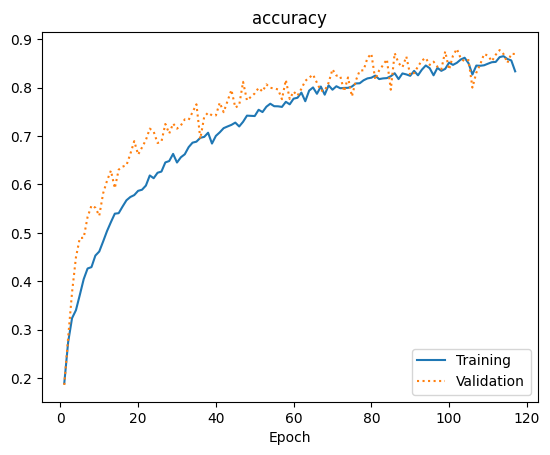

In [9]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
mt.plot_training_history(acc,val_acc,"accuracy")

66/66 [==============================] - 0s 2ms/step
Accuracy: 0.8696693818878773
F1 Score: 0.8690882306635619


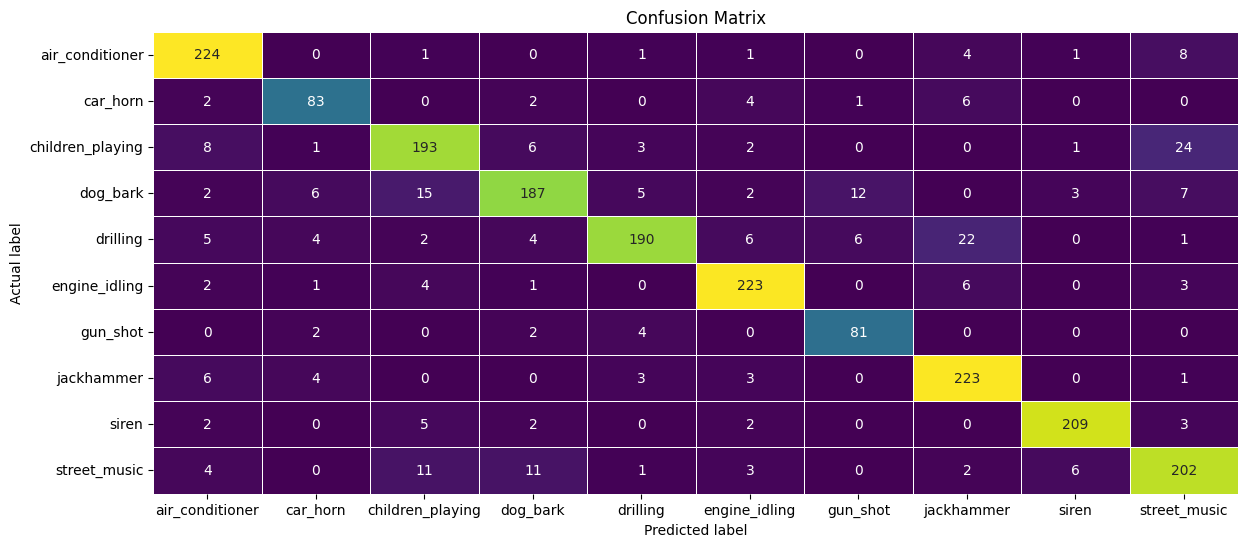

In [10]:
mt.plot_confusion_matrix(model,x_val,y_val,encode)

In [11]:
model = mt.model_load("Models\\temp.h5")
clear_output()
model.save("Models\\Final_Models\\Fully_Connected.h5")

# CNN

The DeppAudioFeatures library is used to extract melspectrograms of a fixed size, 128x81, with everything smaller zero-padded.

Features will be saved as numpy files in the UrbanSound\Features\CNN_Features directory.

In [12]:
fe.CNN_Features_mel("UrbanSound\Train", "UrbanSound\Features\CNN_Features")


No files failed.


In [2]:
x_train, x_val, y_train, y_val, le =  dl.load_data("UrbanSound\Features\CNN_Features", dataset)

In [10]:
model = mt.create_model_CNN(num_classes=10)
learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate = learning_rate ), loss='categorical_crossentropy', metrics=[mt.f1_score, 'accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=15, verbose=1)
checkpoint = ModelCheckpoint( 'Models\\temp.h5',monitor='val_accuracy', verbose=1,   save_best_only=True, mode='max' )


In [ ]:
hist = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100, callbacks = [early_stopping,checkpoint],
    batch_size=32
    )

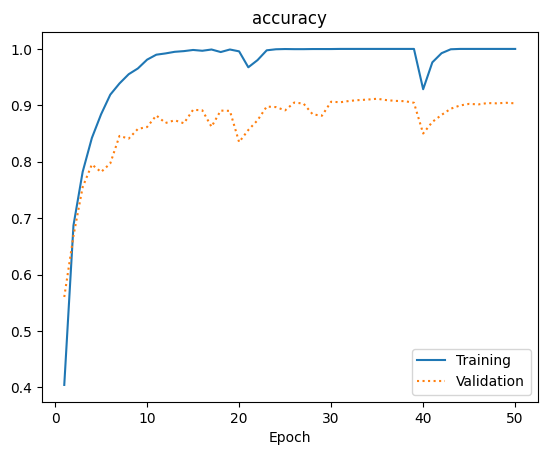

In [12]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
mt.plot_training_history(acc,val_acc,"accuracy")

66/66 [==============================] - 0s 5ms/step
Accuracy: 0.9116523400191022
F1 Score: 0.9113302707735604


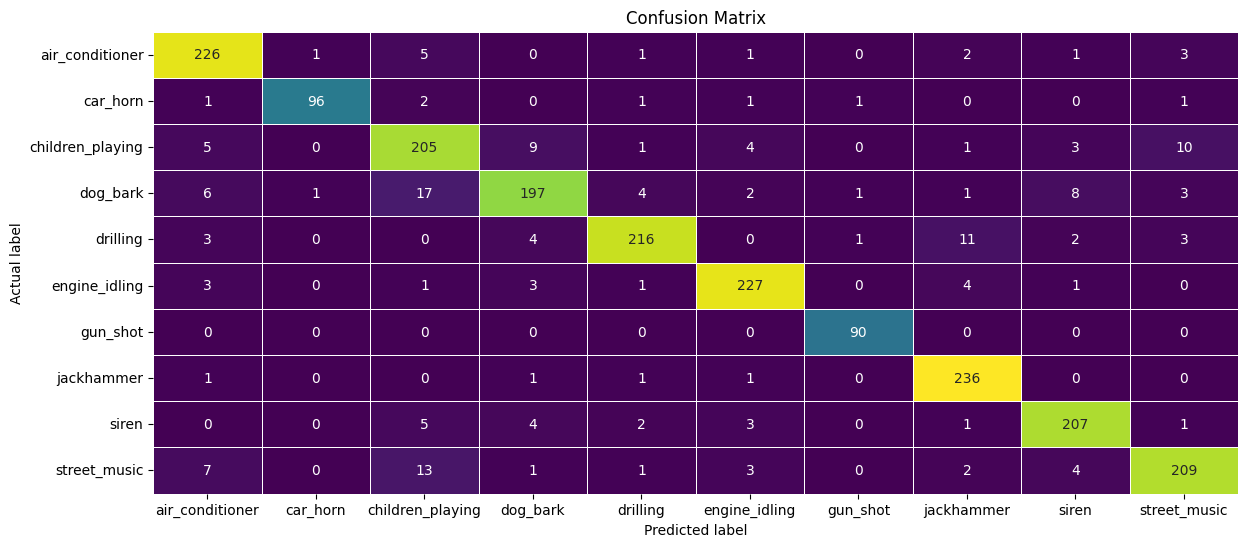

In [15]:
mt.plot_confusion_matrix(model,x_val,y_val,le)


In [16]:
model = mt.model_load("Models\\temp.h5")
clear_output()

model.save("Models\\Final_Models\\UrbanSound_CNN.h5")